In [1]:
%pylab inline
import kwant
kwant.__version__

#from jupyterthemes import jtplot
#jtplot.style(grid=False)

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Pauli matrices  
s_0 = np.array([[1 , 0], [0, 1]])
s_x = np.array([[0 , 1], [1, 0]])
s_y = np.array([[0, -1j], [1j, 0]])
s_z = np.array([[1, 0], [0, -1]])

t=-1

In [3]:
def make_system(W, L, VS, VL, t, return_leads=False):
  
  # Lattice
  lat = kwant.lattice.general([(np.sqrt(3)*1/2, 1/2), (0, 1)],
                              [(0, 0), (1/(2*np.sqrt(3)),1/2)],
                              norbs = 1)
#   lat = kwant.lattice.honeycomb(a=1, norbs=1)
  def scattering_region(pos):
    x, y = pos
    return abs(x) < L/2 and abs(y) < W/2
  
  def lead_shape(pos):
    x, y = pos
    return abs(y) < W/2
  
  sys = kwant.Builder()
  
  sys[lat.shape(scattering_region, (0,0))] = VS
  sys[lat.neighbors()] = t
  
  # Attaching leads
  sym = kwant.TranslationalSymmetry(lat.vec((-2,1)))
  
  L_0 = kwant.Builder(sym)
  L_0[lat.shape(lead_shape, (0,0))] = VL
  L_0[lat.neighbors()] = t
  L_1 = L_0.reversed()
  
  sys.attach_lead(L_0)
  sys.attach_lead(L_1)
  
  if return_leads == True:
    return L_0, L_1, sys
  else: 
    return sys

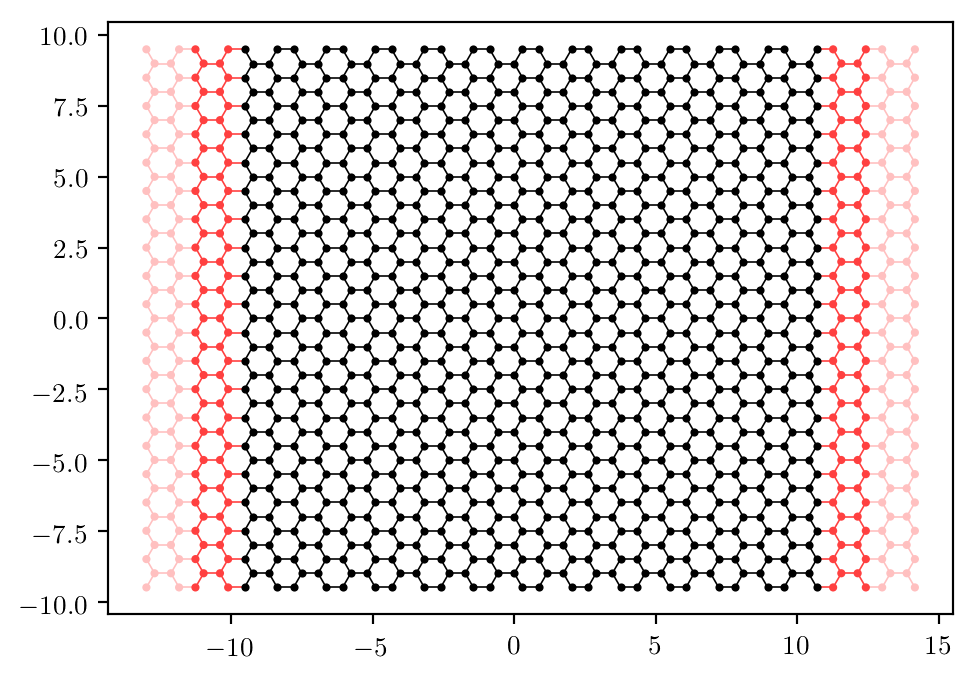

In [4]:
W=20
L=20
L0, L1, syst = make_system(W, L, VS=0.0, VL=0.4, t=t, return_leads=True)
fig=kwant.plot(syst, dpi=196);
fig.savefig("graphene_layer_W={0}L={1}".format(W, L), dpi=196);

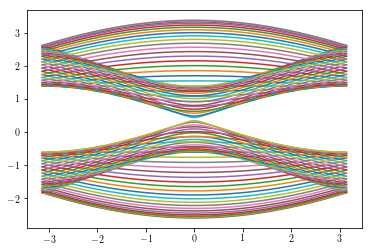

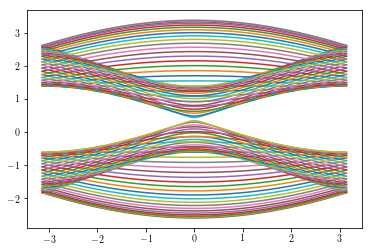

In [5]:
# plot band structures
bands0 = kwant.physics.Bands(L0.finalized())
bands1 = kwant.physics.Bands(L1.finalized())

momenta = np.linspace(-np.pi, np.pi, 101)

plt.figure()
plt.plot(momenta, [bands0(k) for k in momenta], label='bands0');

plt.figure()
plt.plot(momenta, [bands1(k) for k in momenta], label='bands1');

In [8]:
def simulate():
  WperL = np.geomspace(0.5, 7, 16)
  W = 100.0
  Ls = np.ceil(W/WperL).astype(int)
  
  Ts = []
  for L in Ls:
    syst = make_system(W, L, VS=0.0, VL=0.4, t=t)
    smatrix = kwant.smatrix(syst.finalized(), 0.0)
    Ts.append(smatrix.transmission(0, 1))
    
  return np.array(Ts), W/Ls


In [9]:
Ts, WLs = simulate()

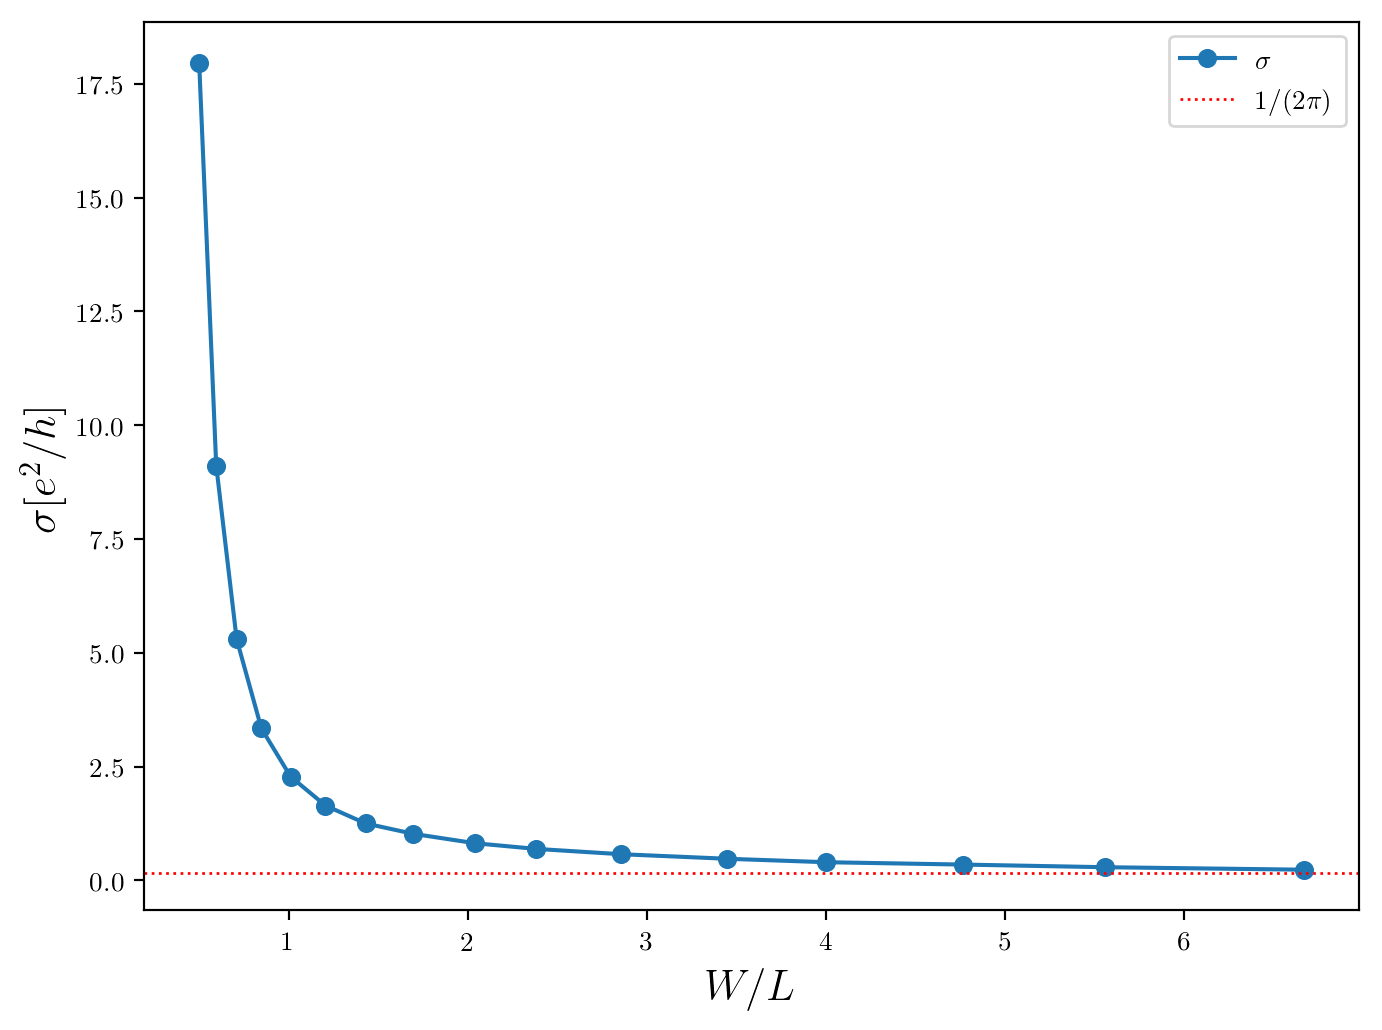

In [10]:
plt.figure(figsize=(8,6), dpi=196)
plt.plot(WLs, 1/(Ts), 'o-', label=r"$\sigma$")
plt.xlabel(r"$W/L$", fontsize=16)
plt.ylabel(r"$\sigma[e^2/h]$", fontsize=16)
plt.axhline(0.5/np.pi, linestyle=':', lw=1, c='r', label=r"$1/(2\pi)$")
plt.legend()
plt.savefig("graphene_conductivity_WL.png", dpi=196)

In [11]:
V_L=0.4
W=300
L=60
energy = 0.0
vg_l = 0.3
def minimalcond():
  Varr = np.linspace(-vg_l, vg_l, 90)
  t = []
  
  for k in range(len(Varr)):
    if (k%10==0 and k != 0):
      print("Step {} done".format(k))
    syst = make_system(W, L, VS=Varr[k], VL=V_L, t=-1)
    smatrix = kwant.smatrix(syst.finalized(), energy)
    t.append(smatrix.transmission(1,0))
  return Varr, np.array(t)

In [12]:
v, t = minimalcond()

Step 10 done
Step 20 done
Step 30 done
Step 40 done
Step 50 done
Step 60 done
Step 70 done
Step 80 done


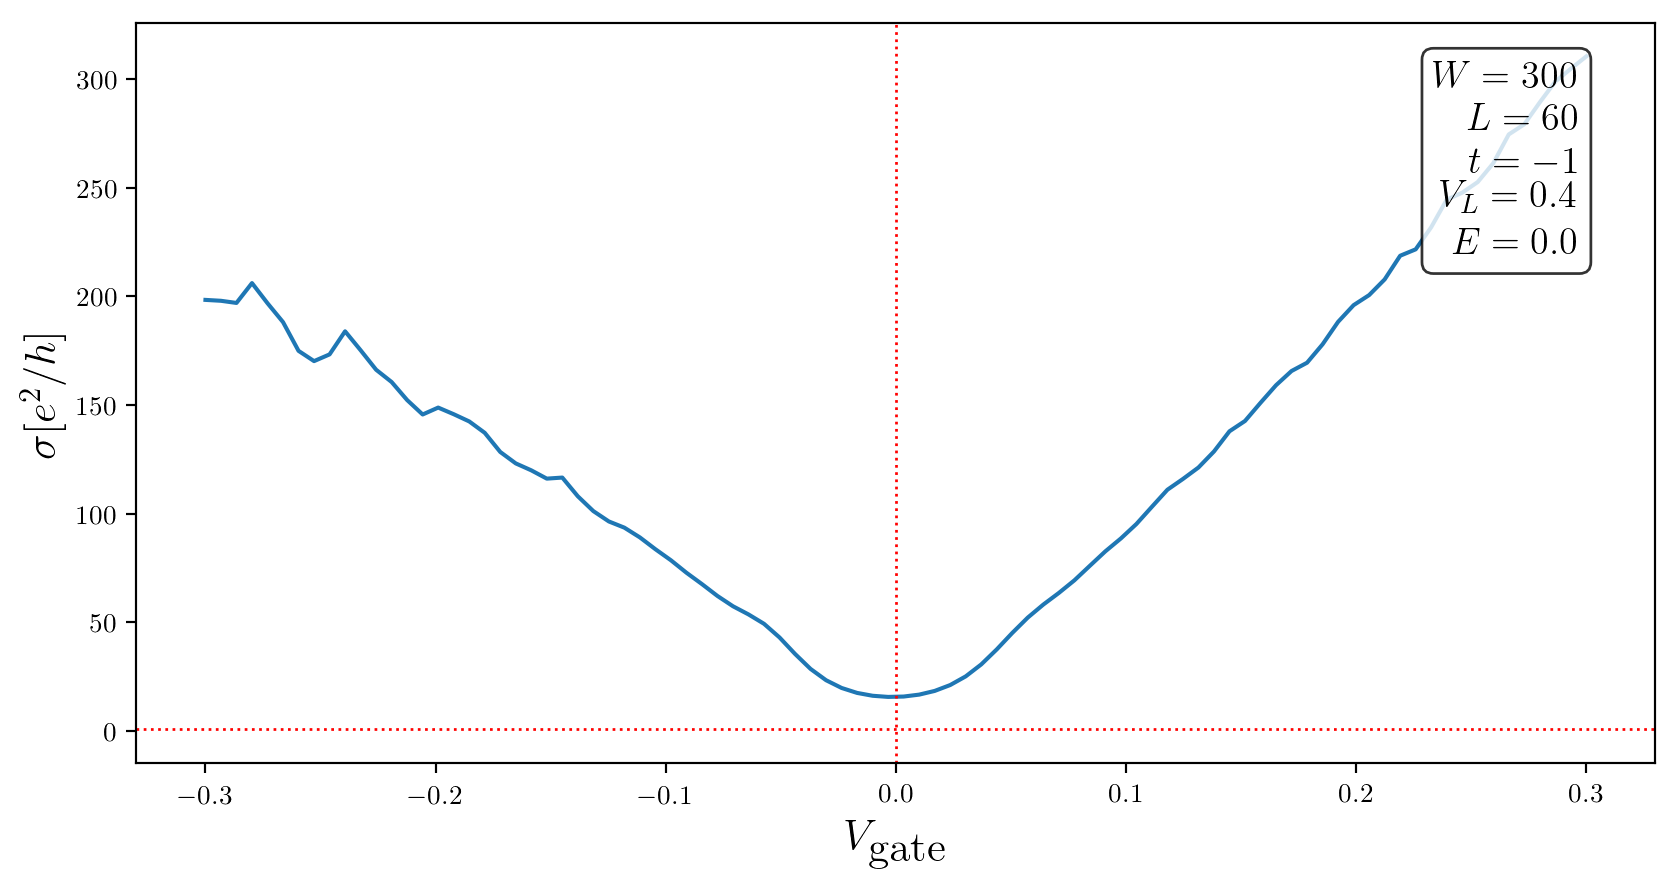

In [13]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=196)

ax.plot(v, (W/L)*t, "-")

textstr = '\n'.join([
    r'$W = {}$'.format(int(W)),
    r'$L = {}$'.format(int(L)),
    r'$t = {}$'.format(-1),
    r'$V_L = {}$'.format(V_L),
    r'$E = {}$'.format(energy)])

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', 
             facecolor='white',
             edgecolor='black', alpha=0.8)

# place a text box in upper left in axes coords
ax.text(0.95, 0.95, textstr,
        transform=ax.transAxes,
        fontsize=14,
        verticalalignment='top',
        horizontalalignment='right', bbox=props)

ax.set_ylabel(r"$\sigma[e^2/h]$", fontsize=16)
ax.set_xlabel(r"$V_{\textrm{gate}}$", fontsize=16)
ax.axhline(1, linestyle=':', lw=1, c='r');
ax.axvline(0, linestyle=':', lw=1, c='r');
fig.savefig("graphene_minimal_vg_l_{}".format("-".join(str(vg_l).split('.'))) + ".png", dpi=196)